<a href="https://colab.research.google.com/github/syuan0525/Deeplearning/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/train.zip")
f.extractall()

In [2]:
import glob
import pandas as pd
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
      "path" : dogs + cats,
      "ans" :[0] * len(dogs) + [1] * len(cats) 
})
df

,path,ans
0,train/dog.6204.jpg,0
1,train/dog.5385.jpg,0
2,train/dog.45.jpg,0
3,train/dog.8417.jpg,0
4,train/dog.11721.jpg,0
...,...,...
24995,train/cat.4358.jpg,1
24996,train/cat.4919.jpg,1
24997,train/cat.1642.jpg,1
24998,train/cat.2213.jpg,1


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
cnn = VGG16(include_top=False,input_shape=(224,224,3))
for l in cnn.layers:
  l.trainable = False
layers = [
    GlobalAveragePooling2D(),
    Dense(2,activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________

In [4]:
# y : 做One-hot encoding很耗ram,直接用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",       
       metrics=["accuracy"])

[[[ 22.060997     0.22100067  -3.6800003 ]
  [ 24.060997     2.2210007   -1.6800003 ]
  [ 24.060997     4.2210007    0.3199997 ]
  ...
  [150.061      138.22101    126.32      ]
  [149.061      138.22101    125.32      ]
  [148.061      137.22101    124.32      ]]

 [[ 25.060997     4.2210007   -1.6800003 ]
  [ 23.060997     2.2210007   -3.6800003 ]
  [ 23.060997     3.2210007   -2.6800003 ]
  ...
  [150.061      138.22101    126.32      ]
  [149.061      138.22101    125.32      ]
  [149.061      137.22101    125.32      ]]

 [[ 23.060997     2.2210007   -4.6800003 ]
  [ 21.060997     0.22100067  -5.6800003 ]
  [ 14.060997    -4.7789993  -11.68      ]
  ...
  [150.061      138.22101    127.32      ]
  [149.061      137.22101    126.32      ]
  [150.061      138.22101    127.32      ]]

 ...

 [[-23.939003   -46.779      -85.68      ]
  [-20.939003   -42.779      -85.68      ]
  [-13.939003   -36.779      -84.68      ]
  ...
  [-16.939003   -16.779        9.32      ]
  [-17.939003   -1

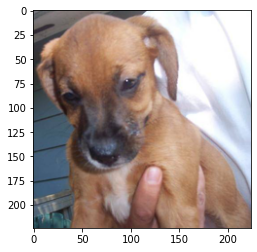

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
p = df["path"]
idx = random.randint(0,len(p)-1)
img = Image.open(p[idx]).resize((224,224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [6]:
x = np.array(df["path"])
y = np.array(df["ans"]) 

In [7]:
def data_generator(x, y, batch_size=20):
  while True:
    idx = np.random.randint(0, len(x), size=batch_size)
    x_batch, y_batch = x[idx], y[idx]
    x_final = []
    for path in x_batch:
      img = Image.open(path).resize((224,224)).convert("RGB")
      img_pre = preprocess_input(np.array(img))
      x_final.append(img_pre)
    x_final = np.array(x_final)
    y_batch = np.array(y_batch)
    yield (x_final,y_batch)
gen = data_generator(x,y)
x_gen,y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(20, 224, 224, 3)
(20,)


In [8]:
from sklearn.model_selection import train_test_split
dogx= x[y == 0]
catx= x[y == 1]
dog1000 = np.random.choice(dogx, 1000, replace=False)
dog900, dog100 = train_test_split(dog1000, test_size=0.1)
cat1000 = np.random.choice(catx, 1000, replace=False) 
cat900, cat100 = train_test_split(cat1000, test_size=0.1)
x_train = np.concatenate((dog900,cat900))
y_train = np.array([0]*len(dog900)+[1]*len(cat900))
x_test = np.concatenate((dog100,cat100))
y_test = np.array([0]*len(dog100)+[1]*len(cat100))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800,)
(200,)
(1800,)
(200,)


In [9]:
train_generator = data_generator(x_train,y_train)
test_generator = data_generator(x_test,y_test)

In [11]:
model.fit_generator(train_generator,
          steps_per_epoch=50,
          epochs=2,
          validation_data=test_generator,
          validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
50/50 [==============================] - 558s 11s/step - loss: 1.5785 - accuracy: 0.7160 - val_loss: 0.3984 - val_accuracy: 0.9300
Epoch 2/2
50/50 [==============================] - 559s 11s/step - loss: 0.2465 - accuracy: 0.9230 - val_loss: 0.3606 - val_accuracy: 0.9100
